In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

In [6]:
from sklearn.model_selection import train_test_split
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor

import math
from statistics import mean
from datetime import timedelta
from sklearn.metrics import mean_squared_error


#from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

from datetime import date
import datetime
import holidays

In [7]:
status = pd.read_csv('../../../status.csv')

In [8]:
#statusのyear, month, dayを結合してdatetime型に
status['date'] = status['year'].astype(str) + '/' + status['month'].astype(str).str.zfill(2).astype(str) + '/' + status['day'].astype(str).str.zfill(2).astype(str) + '/' + status['hour'].astype(str).str.zfill(2).astype(str)
status['date'] = pd.to_datetime(status['date'], format='%Y/%m/%d/%H', infer_datetime_format=True)

#曜日を追加するための関数を定義
def get_weekday_jp(dt):
    w_list = ['月曜日', '火曜日', '水曜日', '木曜日', '金曜日', '土曜日', '日曜日']
    return(w_list[dt.weekday()])

#dateから曜日情報を取得
status["weekday"] = status["date"].apply(get_weekday_jp)

main_df = status[['date','hour', 'station_id', 'bikes_available', 'weekday', 'predict']]

#カテゴリ変数をダミー変数化
main_df = pd.get_dummies(main_df)

train = main_df[main_df['date'] >= '2013-10-01']
train = train[train['date'] < '2013-11-01']
train = train[train['station_id'] == 0] 

test = main_df[main_df['date'] >= '2013-11-01']
test = test[test['date'] < '2013-11-08']
test = test[test['station_id'] == 0] 

#predictは特徴量として必要ないため、削除
train = train.drop("predict",axis=1)
train_df = train 


#predictは特徴量として必要ないため、削除
train_week_X  = train.drop("station_id",axis=1)
train_week_X = train_week_X.drop("date",axis=1)

train_week_X = train_week_X.drop('bikes_available', axis = 1)
train_week_y = train['bikes_available']

In [9]:
reg_mod = xgb.XGBRegressor(objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.10,
    subsample=0.5,
    colsample_bytree=1, 
    max_depth=5,
)
reg_mod.fit(train_week_X, train_week_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=6,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [11]:
predictions = reg_mod.predict(train_week_X)

In [12]:
train_visualization_lightgbm = status[status['date'] >= '2013-10-01']
train_visualization_lightgbm = train_visualization_lightgbm[train_visualization_lightgbm['date'] < '2013-11-01']
train_visualization_lightgbm = train_visualization_lightgbm[train_visualization_lightgbm['station_id'] == 0] 

train_visualization_lightgbm['predict'] = predictions

train_visualization_lightgbm['date_hour'] = train_visualization_lightgbm['year'].astype(str) + '/' + train_visualization_lightgbm['month'].astype(str).str.zfill(2).astype(str) + '/' + train_visualization_lightgbm['day'].astype(str).str.zfill(2).astype(str) + '/' + train_visualization_lightgbm['hour'].astype(str).str.zfill(2).astype(str)
train_visualization_lightgbm['date_hour'] = pd.to_datetime(train_visualization_lightgbm['date_hour'], format='%Y/%m/%d/%H', infer_datetime_format=True)
train_visualization_lightgbm

,id,year,month,day,hour,station_id,bikes_available,predict,date,weekday,date_hour
720,720,2013,10,1,0,0,16.0,18.057854,2013-10-01 00:00:00,火曜日,2013-10-01 00:00:00
721,721,2013,10,1,1,0,14.0,17.473398,2013-10-01 01:00:00,火曜日,2013-10-01 01:00:00
722,722,2013,10,1,2,0,14.0,17.316576,2013-10-01 02:00:00,火曜日,2013-10-01 02:00:00
723,723,2013,10,1,3,0,14.0,17.495169,2013-10-01 03:00:00,火曜日,2013-10-01 03:00:00
724,724,2013,10,1,4,0,14.0,17.495089,2013-10-01 04:00:00,火曜日,2013-10-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...
1459,1459,2013,10,31,19,0,19.0,18.844049,2013-10-31 19:00:00,木曜日,2013-10-31 19:00:00
1460,1460,2013,10,31,20,0,18.0,18.130863,2013-10-31 20:00:00,木曜日,2013-10-31 20:00:00
1461,1461,2013,10,31,21,0,18.0,17.603451,2013-10-31 21:00:00,木曜日,2013-10-31 21:00:00
1462,1462,2013,10,31,22,0,18.0,17.565845,2013-10-31 22:00:00,木曜日,2013-10-31 22:00:00


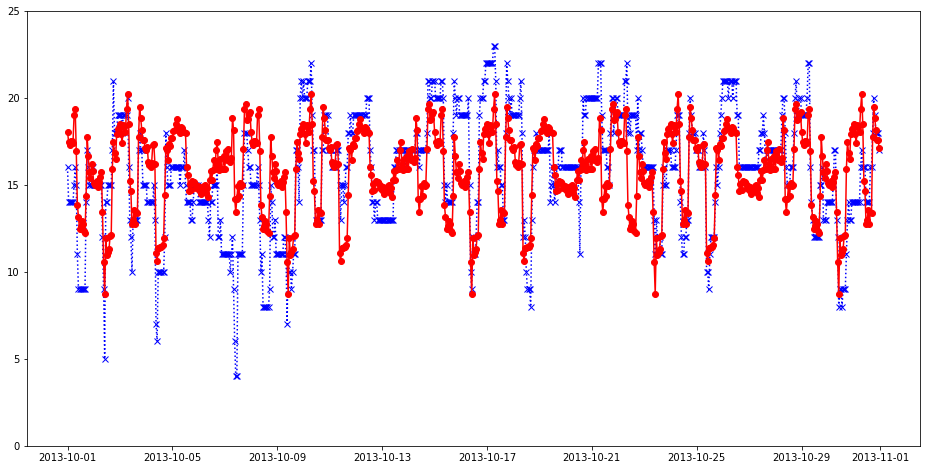

In [13]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['predict'], color = 'red', marker = 'o', linestyle = '-', label = 'answer')

In [14]:
#trainデータのrmse
mean_squared_error(train_visualization_lightgbm['predict'].values, train_visualization_lightgbm['bikes_available'].values, squared=False)

2.446644940268162

In [15]:
#predictは特徴量として必要ないため、削除
test_week_X  = test.drop("station_id",axis=1)
test_week_X = test_week_X.drop("date",axis=1)
test_week_X = test_week_X.drop("predict",axis=1)

test_week_X = test_week_X.drop('bikes_available', axis = 1)
test_week_y = test['bikes_available']

pred_lightgbm_test = reg_mod.predict(test_week_X)

In [16]:
#2014/09/01以前をtrain、以後をtestに分割(testはpredict = 1のものに絞る)
test_visualization_lightgbm = status[status['date'] >= '2013-11-01']
test_visualization_lightgbm = test_visualization_lightgbm[test_visualization_lightgbm['date'] < '2013-11-08']
test_visualization_lightgbm = test_visualization_lightgbm[test_visualization_lightgbm['station_id'] == 0] 

test_visualization_lightgbm['predict'] = pred_lightgbm_test

test_visualization_lightgbm['date_hour'] = test_visualization_lightgbm['year'].astype(str) + '/' + test_visualization_lightgbm['month'].astype(str).str.zfill(2).astype(str) + '/' + test_visualization_lightgbm['day'].astype(str).str.zfill(2).astype(str) + '/' + test_visualization_lightgbm['hour'].astype(str).str.zfill(2).astype(str)
test_visualization_lightgbm['date_hour'] = pd.to_datetime(test_visualization_lightgbm['date_hour'], format='%Y/%m/%d/%H', infer_datetime_format=True)

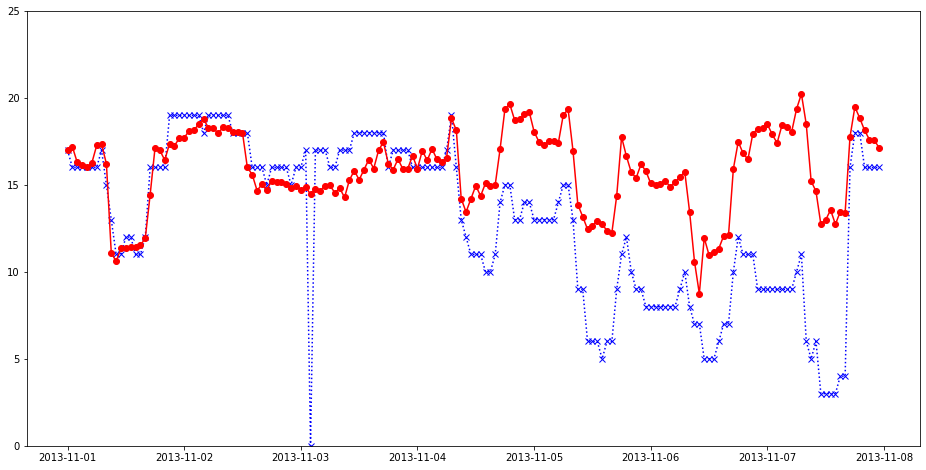

In [17]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['predict'], color = 'red', marker = 'o', linestyle = '-', label = 'answer')

In [18]:
#trainデータのrmse
mean_squared_error(test_visualization_lightgbm['predict'].values, test_visualization_lightgbm['bikes_available'].values, squared=False)

4.839520265845521

In [1]:
#trainデータのrmse
mean_squared_error(test_visualization_lightgbm['predict'].values, test_visualization_lightgbm['bikes_available'].values, squared=False)

NameError: name 'mean_squared_error' is not defined